**7.6. Residual Networks (ResNet)**

Theory : https://d2l.ai/chapter_convolutional-modern/resnet.html

Code : https://github.com/d2l-ai/d2l-en/blob/master/chapter_convolutional-modern/resnet.md

**7.6.1. Function Classes**

**7.6.2. Residual Blocks**

In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 2.0 MB/s 


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Now let us look at a situation where the input and output are of the same shape.

In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

We also have the option to halve the output height and width while increasing the number of output channels.

In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

**7.6.3. ResNet Model**

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the  7×7  convolutional layer with 64 output channels and a stride of 2 is followed by the  3×3  maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks. However, ResNet uses four modules made up of residual blocks, each of which ** uses several residual blocks with the same number of output channels**. The number of channels in the first module is the same as the number of input channels. 

Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

Finally, just like GoogLeNet, we add a global average pooling layer, followed by the fully-connected layer output.

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

Before training ResNet, let us observe how the input shape changes across different modules in ResNet. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


**7.6.4. Training**
We train ResNet on the Fashion-MNIST dataset, just like before.

loss 0.019, train acc 0.995, test acc 0.918
1601.4 examples/sec on cuda:0


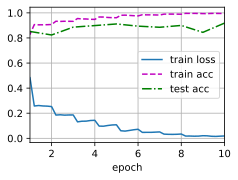

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**7.6.5. Summary**

Nested function classes are desirable. Learning an additional layer in deep neural networks as an identity function (though this is an extreme case) should be made easy.

The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero.

We can train an effective deep neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers.

ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional and sequential nature.